# Fitting various chromatic stimuli to your LED setup

In [1]:
import numpy as np
from scipy.stats import norm, truncnorm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dreye import (
    IntensityFit, RelativeIntensityFit, 
    IndependentExcitationFit, TransformExcitationFit, 
    ReflectanceExcitationFit
)
from dreye import create_led_spectra_container, get_photoreceptor_model, Spectrum, Spectra, create_gaussian_spectrum

np.random.seed(10)

## Setup your LED system

Let's say we have six LEDs that all have a gaussian spectral distribution with different peaks. The intensities of the LEDs range from 0 micro photon flux to different max intensities. To turn on our LEDs we send voltage values from 0 to 5 volts. We will also add some noise to our spectral distributions (as in real measurements).

Here, we are using a convenience function to create a `MeasuredSpectra` class that containes all of our `dummy` measurements:

In [2]:
wavelengths = np.arange(300, 700.5, 0.5)
max_ints = np.array([100, 110, 90, 120, 130, 150])
measured_spectra = create_led_spectra_container(
    led_spectra=(
        norm.pdf(
            wavelengths[:, None], 
            np.array([340, 385, 417, 530, 565, 612])[None], 
            15
        ) + np.random.normal(0, 0.001, (wavelengths.size, 6))
    ), 
    intensity_bounds=(np.zeros(6), max_ints), 
    wavelengths=wavelengths, 
    output_bounds=(0, 5), 
    intensity_units='microphotonflux', 
    output_units='volts', 
    steps=10
)

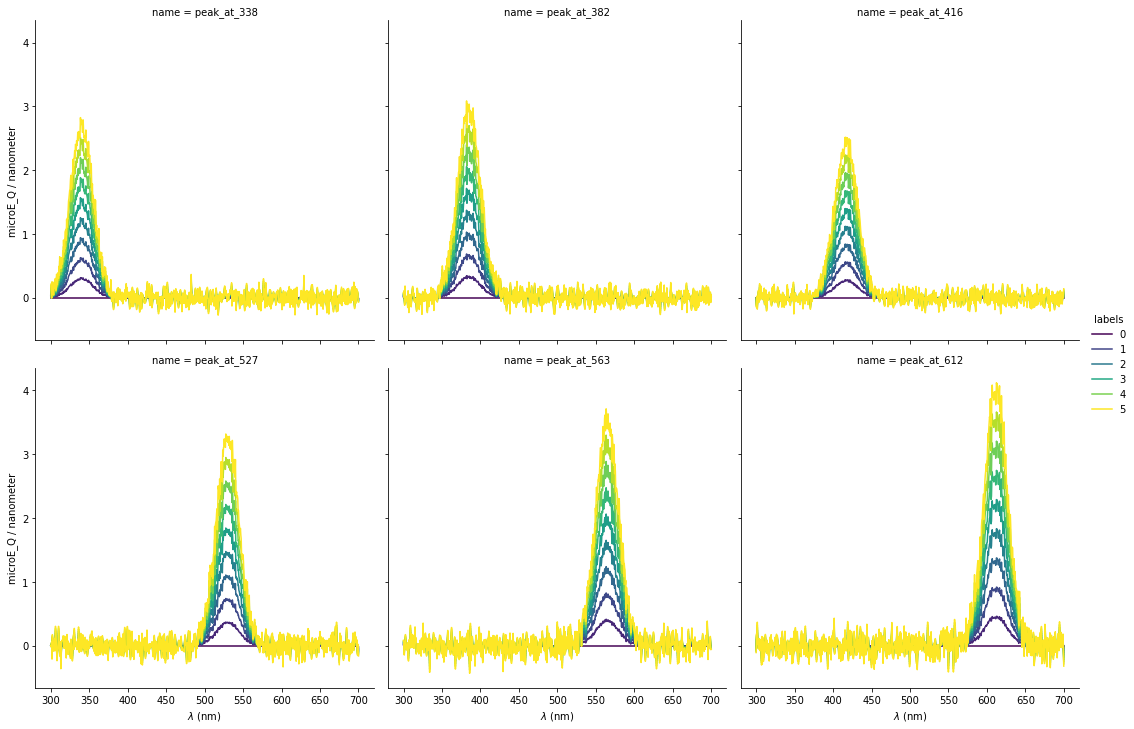

In [3]:
measured_spectra.plot()

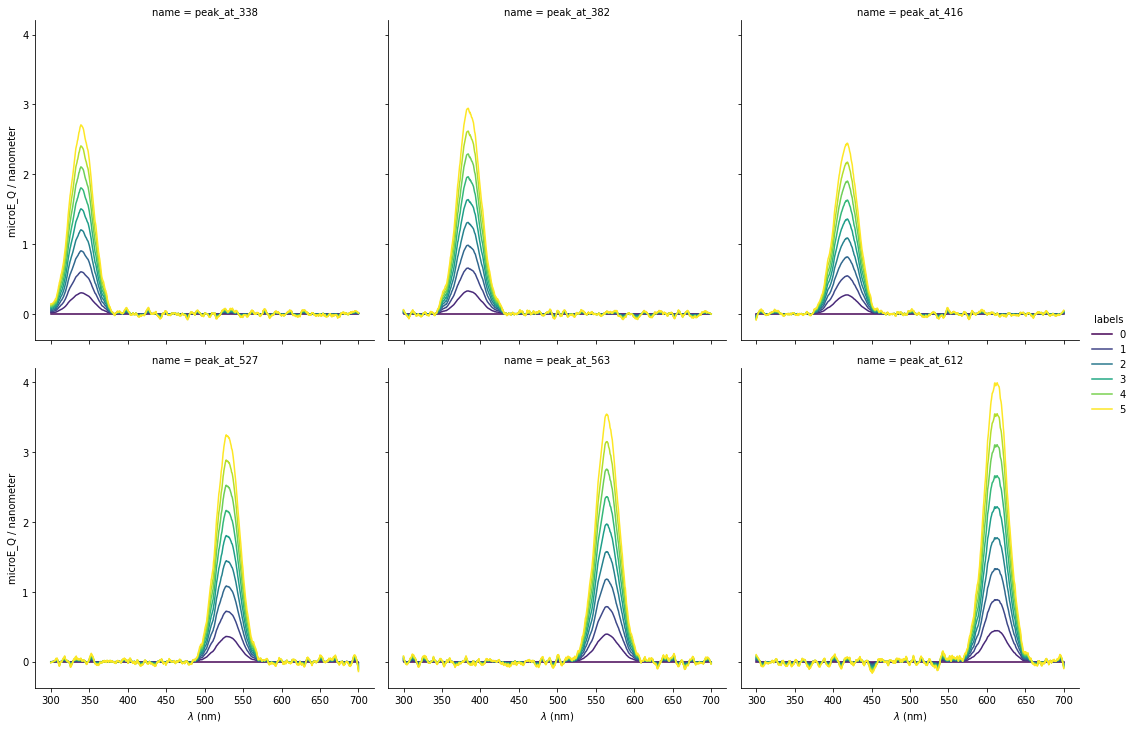

In [4]:
# we can smooth out the spectra to remove some noise
measured_spectra.smooth(10).plot()

## Fitting intensity values to the correct output

In [5]:
int_model = IntensityFit(measured_spectra=measured_spectra.smooth(10))

In [6]:
# intensities to map
X = np.random.random((10, 6)) * max_ints[None]
volt_values = int_model.fit_transform(X)
int_model.score()

1.0

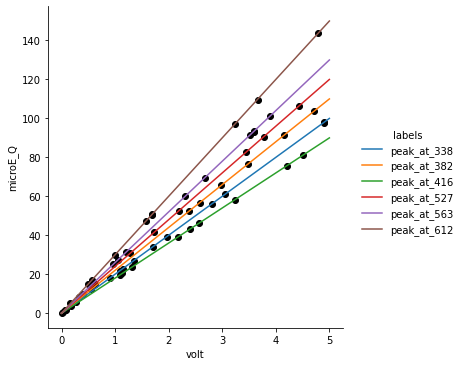

In [7]:
measured_spectra.intensities.plot()
plt.scatter(volt_values, X, color='black')

## Fitting relative intensity values to the correct output

The relative intensity model also requires you to specify other options: The intensity values of the LEDs for the background, and an optional `rtype` argument. The `rtype` specifies the measure:

* `None`: intensity/bg_intensity
* `fechner` or `log`: log(intensity/bg_intensity)
* `weber`: (intensity-bg_intensity)/bg_intensity

In [8]:
bg_ints = np.array([5, 10, 15, 20, 5, 5])

In [9]:
relint_model = RelativeIntensityFit(
    measured_spectra=measured_spectra.smooth(10), 
    bg_ints=bg_ints, 
    rtype='fechner'
)

In [10]:
X = truncnorm.rvs(-3, 3, loc=0, scale=1, size=(10, 6))
volt_values = relint_model.fit_transform(X)
relint_model.score()

1.0

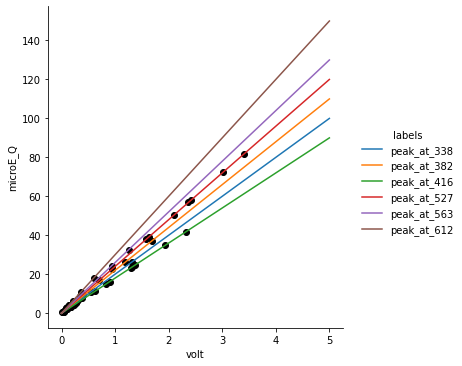

In [11]:
measured_spectra.intensities.plot()
plt.scatter(volt_values, relint_model.fitted_intensities_, color='black')
# plt.yscale('log')

## Fitting photoreceptor excitations to your LED system

In order to fit photoreceptor excitations given your LED system, you first need to specify a photoreceptor model. Here, we are going to work with a "dummy" photoreceptor model (i.e. we are going to generate spectral sensitivities from the gaussian). In our photoreceptor model, we will say that the photoreceptor excitation correspond to the log of the relative photon capture.

In [12]:
peaks = np.array([400, 465, 650])
pr_model = get_photoreceptor_model(
    3, wavelengths=wavelengths, 
    labels=['o1', 'o2', 'o3'], 
    photoreceptor_type='log'
)

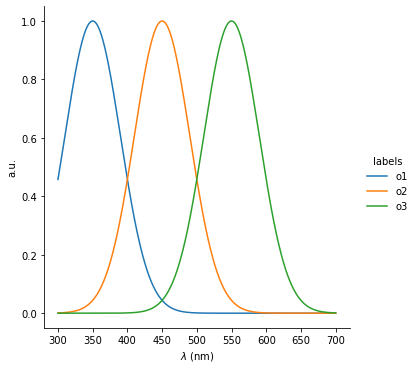

In [13]:
pr_model.sensitivity.plot()

Using this model, we can calculate the photoreceptor excitation or capture using a given spectral distribution. First, let's create some spectral distributions:

4.9937578027465666 <Unit('microspectral_E_Q * nanometer')>

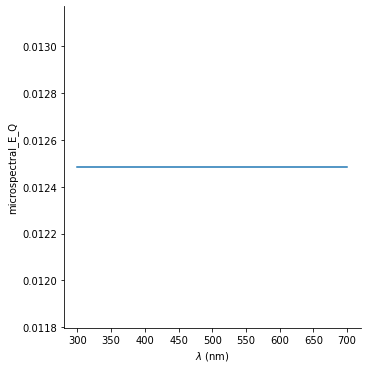

In [14]:
# flat background
background = Spectrum(
    np.ones(wavelengths.size)/wavelengths.size * 10, 
    domain=wavelengths, 
    units='microspectralphotonflux'
)
background.plot()
background.integral

Magnitude,[14.993757802746698 14.993757802746684 14.993757802746668 14.993757802746675 14.993757802746652 14.993757802746643 14.993757802746634 14.993757802746638 14.993757802746597 14.993757802746599]
Units,microspectral_E_Q nanometer


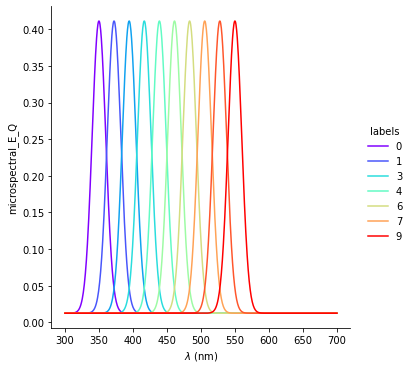

In [15]:
gaussians = create_gaussian_spectrum(
    wavelengths=wavelengths, 
    centers=np.linspace(350, 550, 10), 
    std=10, 
    intensity=10, 
    background=background, 
    add_background=True, 
)
gaussians.plot(palette='rainbow')
gaussians.integral

Now we can calculate the photon capture/excitation given these the spectra:

In [16]:
q = pr_model.capture(
    gaussians.magnitude, 
    background=background.magnitude
)
q

array([[9.66586687, 1.40927945, 1.00006026],
       [8.49434337, 2.30811723, 1.00071177],
       [5.8472846 , 4.12692024, 1.00628807],
       [3.34480504, 6.5902371 , 1.04154662],
       [1.84831715, 8.47458251, 1.2053041 ],
       [1.22953718, 8.47458251, 1.75875721],
       [1.04645058, 6.5902371 , 3.09725542],
       [1.00703028, 4.12692024, 5.33553908],
       [1.00079579, 2.30811723, 7.7031382 ],
       [1.00006737, 1.40927934, 8.75097845]])

In [17]:
f = pr_model.excitation(
    gaussians, 
    background=background, 
    return_units=False
)
f

array([[2.26860080e+00, 3.43078547e-01, 6.02555041e-05],
       [2.13940046e+00, 8.36432142e-01, 7.11520183e-04],
       [1.76597738e+00, 1.41753142e+00, 6.26837843e-03],
       [1.20740841e+00, 1.88558933e+00, 4.07067441e-02],
       [6.14275575e-01, 2.13707139e+00, 1.86731902e-01],
       [2.06637822e-01, 2.13707139e+00, 5.64607430e-01],
       [4.54040359e-02, 1.88558933e+00, 1.13051637e+00],
       [7.00568073e-03, 1.41753142e+00, 1.67438993e+00],
       [7.95471100e-04, 8.36432142e-01, 2.04162780e+00],
       [6.73675059e-05, 3.43078464e-01, 2.16916552e+00]])

In [18]:
f = pr_model.excitation(
    gaussians, 
    background=background, 
    return_units=True
)
f

Magnitude,[[2.268600800577495 0.34307854692744666 6.025550414293734e-05] [2.1394004562320856 0.8364321416416269 0.0007115201832812348] [1.765977382087214 1.4175314246285808 0.006268378430209294] [1.2074084071616766 1.8855893270838897 0.04070674412765183] [0.6142755749969758 2.1370713912449903 0.18673190184792635] [0.20663782161144947 2.1370713912449903 0.5646074296610938] [0.04540403587243968 1.885589327083891 1.130516369527981] [0.007005680728198353 1.4175314246285817 1.6743899253420984] [0.000795471099772639 0.8364321416414798 2.0416278044139817] [6.736750587474043e-05 0.3430784644584676 2.169165517373217]]
Units,dimensionless


In [19]:
# photoreceptor excitation in this model is the log of the photon capture
np.all(np.log(q) == f)

True

We can use our photoreceptor model also to fit various desired excitation values given our LED system using `IndependentExcitationFit`:

In [20]:
exc_model = IndependentExcitationFit(
    photoreceptor_model=pr_model, 
    fit_weights=np.array([0.3, 1, 1]), 
    background=background, 
    measured_spectra=measured_spectra.smooth(10), 
)

In [21]:
X = np.random.normal(0, 2.5, size=(10, 3))
volt_values = exc_model.fit_transform(X)
exc_model.score()

/Users/matthias.christenson/Documents/dreye/dreye/estimators/excitation_models.py:274: UserWarning: Assuming the `background` illuminant will be simulated using the LEDs. Fitted background intensities: [0.3259011775503935, 0.7160405889122785, 1.29886336231548, 0.7909276488678475, 0.5813774998002597, 0.22573437171169217].
  warnings.warn(


0.6131596961050187

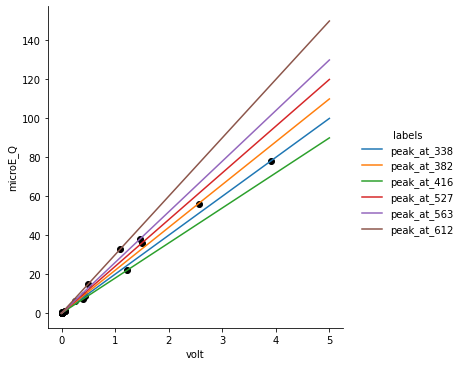

In [22]:
measured_spectra.intensities.plot()
plt.scatter(volt_values, exc_model.fitted_intensities_, color='black')

In [23]:
exc_model.feature_scores()

array([0.07320086, 0.88158212, 0.88469611])

In [24]:
exc_model.sample_scores()

array([ 0.66126175,  0.6138196 ,  1.        ,  0.43521382,  0.1020027 ,
       -0.30970552,  1.        ,  0.4313183 ,  1.        ,  0.99971567])

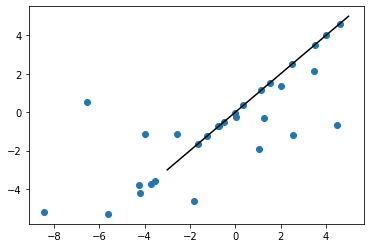

In [25]:
plt.scatter(
    exc_model.excite_X_, exc_model.fitted_excite_X_, 
)
plt.plot([-3, 5], [-3, 5], color='black')

## Fitting Spectral distributions given a photoreceptor model and LED system

Let's create a second set of gaussians, but this time we do not add the background and we want to just use these gaussians as filters (so we max normalize them: Notice the change in units on the y axis). 

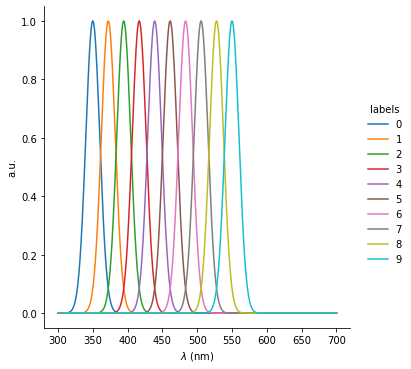

In [26]:
gaussians = create_gaussian_spectrum(
    wavelengths=wavelengths, 
    centers=np.linspace(350, 550, 10), 
    std=10, 
    intensity=1, 
    background=background, 
    add_background=False, 
).max_normalized
gaussians.plot()

In [27]:
ref_model = ReflectanceExcitationFit(
    reflectances=gaussians, 
    photoreceptor_model=pr_model, 
    fit_weights=np.array([0.3, 1, 1]), 
    background=background, 
    measured_spectra=measured_spectra.smooth(10), 
    add_background=True, 
    filter_background=True
)

In [28]:
gaussians.shape

(801, 10)

In [29]:
# this time X describes luminant multiples!
X = np.concatenate(np.array([-1, 100, 1000])[:, None, None] * np.eye(10)[None], axis=0)
print(X.shape)
X[:5]

(30, 10)


array([[-1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -1., -0., -0., -0., -0., -0.]])

In [30]:
volt_values = ref_model.fit_transform(X)
ref_model.score()

/Users/matthias.christenson/Documents/dreye/dreye/estimators/excitation_models.py:274: UserWarning: Assuming the `background` illuminant will be simulated using the LEDs. Fitted background intensities: [0.3259011775503935, 0.7160405889122785, 1.29886336231548, 0.7909276488678475, 0.5813774998002597, 0.22573437171169217].
  warnings.warn(


0.8638958078210354

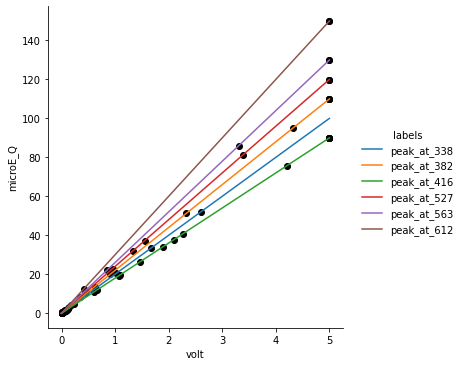

In [31]:
measured_spectra.intensities.plot()
plt.scatter(volt_values, ref_model.fitted_intensities_, color='black')

In [32]:
ref_model.feature_scores()

array([0.63692275, 0.95915826, 0.99560641])

In [33]:
ref_model.sample_scores()

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.73835431,
        0.25583239,  0.24745973,  0.69469623,  1.        ,  1.        ,
        0.88286246,  0.8971349 ,  0.93077564,  0.92755574,  0.57843607,
       -0.14504795,  0.39331435,  0.35046083,  0.70536663,  0.91758488])

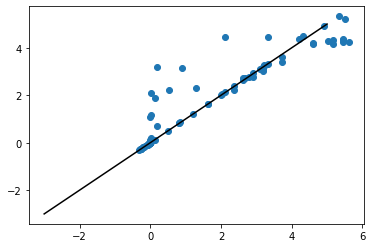

In [34]:
plt.scatter(
    ref_model.excite_X_, ref_model.fitted_excite_X_, 
)
plt.plot([-3, 5], [-3, 5], color='black')

## Fitting transformations of photoreceptor excitation values

Besides fitting photoreceptor excitations directly, you can also fit a linear transformation of photoreceptor excitations (given a linear transform):

In [35]:
linear_transform = np.array([
    [3, 3, 5], 
    [1, 1, -2], 
    [-1, 2, -1]
])
inv_transform = np.linalg.inv(linear_transform)

In [36]:
t_model = TransformExcitationFit(
    linear_transform=linear_transform, 
    inv_transform=inv_transform,
    photoreceptor_model=pr_model, 
    fit_weights=np.array([0.3, 1, 1]), 
    background=background, 
    measured_spectra=measured_spectra.smooth(10), 
    fit_to_transform=True
)

In [37]:
X = np.random.normal(0, 2, size=(10, 3))
volt_values = t_model.fit_transform(X)
t_model.score()

/Users/matthias.christenson/Documents/dreye/dreye/estimators/excitation_models.py:274: UserWarning: Assuming the `background` illuminant will be simulated using the LEDs. Fitted background intensities: [0.3259011775503935, 0.7160405889122785, 1.29886336231548, 0.7909276488678475, 0.5813774998002597, 0.22573437171169217].
  warnings.warn(


0.891585430469374

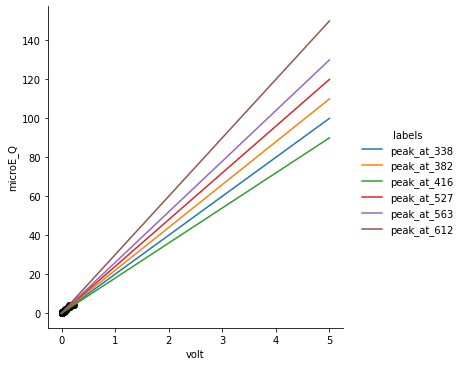

In [38]:
measured_spectra.intensities.plot()
plt.scatter(volt_values, t_model.fitted_intensities_, color='black')

In [39]:
t_model.feature_scores()

array([0.67859877, 0.99996601, 0.99619151])

In [40]:
t_model.sample_scores()

array([1.        , 0.94512878, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.55991551, 1.        ])

You can plot the fits in excitation space and the linear transform space

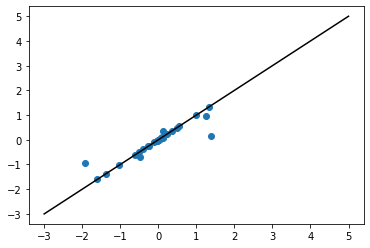

In [41]:
plt.scatter(
    t_model.excite_X_, t_model.fitted_excite_X_, 
)
plt.plot([-3, 5], [-3, 5], color='black')

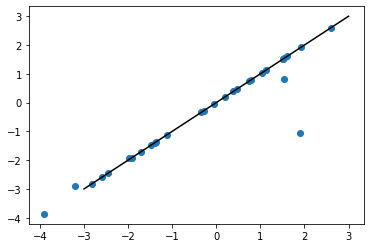

In [42]:
plt.scatter(
    t_model.transform_X_, t_model.fitted_transform_X_, 
)
plt.plot([-3, 3], [-3, 3], color='black')

## Non-linear transformations

In [154]:
comps = np.array([
    [1, -1, 0], 
    [1, 0.5, 1], 
    [1, 0.5, -1]
])
inv_comps = np.linalg.inv(comps)

def transform_func(X):
    CX = X @ comps
    ach = CX[..., 0]
    sat = np.linalg.norm(CX[..., 1:], axis=-1)
    hue = np.arctan2(CX[..., 1], CX[..., 2])
    return np.array([ach, sat, hue]).T

def inv_func(X):
    CX = np.zeros(X.shape)
    CX[..., 0] = X[..., 0]
    CX[..., 2] = X[..., 1] * np.cos(X[..., 2])
    CX[..., 1] = X[..., 1] * np.sin(X[..., 2])
    return CX @ inv_comps
    

In [155]:
from dreye.estimators.excitation_models import NonlinearTransformExcitationFit

In [230]:
t_model = NonlinearTransformExcitationFit(
    transform_func=transform_func, 
    inv_func=inv_func,
    photoreceptor_model=pr_model, 
    fit_weights=np.array([0.3, 1, 1]), 
    bg_ints=np.ones(len(measured_spectra)),
    #background=background, 
    measured_spectra=measured_spectra.smooth(10), 
    fit_to_transform=True, 
    ignore_bounds=True
)

In [231]:
hues = np.arange(-np.pi, np.pi, np.pi/6)
X = np.ones((hues.size, 3))
X[:, 1] *= 2
X[:, -1] = hues
X

array([[ 1.00000000e+00,  2.00000000e+00, -3.14159265e+00],
       [ 1.00000000e+00,  2.00000000e+00, -2.61799388e+00],
       [ 1.00000000e+00,  2.00000000e+00, -2.09439510e+00],
       [ 1.00000000e+00,  2.00000000e+00, -1.57079633e+00],
       [ 1.00000000e+00,  2.00000000e+00, -1.04719755e+00],
       [ 1.00000000e+00,  2.00000000e+00, -5.23598776e-01],
       [ 1.00000000e+00,  2.00000000e+00, -8.88178420e-16],
       [ 1.00000000e+00,  2.00000000e+00,  5.23598776e-01],
       [ 1.00000000e+00,  2.00000000e+00,  1.04719755e+00],
       [ 1.00000000e+00,  2.00000000e+00,  1.57079633e+00],
       [ 1.00000000e+00,  2.00000000e+00,  2.09439510e+00],
       [ 1.00000000e+00,  2.00000000e+00,  2.61799388e+00]])

In [232]:
t_model.fit(X)

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.9/site-packages/scipy/optimize/_lsq/trf_linear.py:117: RuntimeWarning: invalid value encountered in multiply
  r_h = p_h + r_h * r_stride


NonlinearTransformExcitationFit(bg_ints=array([1., 1., 1., 1., 1., 1.]),
                                fit_to_transform=True,
                                fit_weights=array([0.3, 1. , 1. ]),
                                ignore_bounds=True,
                                inv_func=<function inv_func at 0x7ff0fcc97550>,
                                measured_spectra=MeasuredSpectraContainer([[0.0 0.015643348472519376 0.03128669694503875 ... 0.10950343930763562  0.125146787780155 0.14079013625267447] [0.0 0.0156712998556055...0.0 -0.0068637620201226855 -0.013727524040245371 ...  -0.04804633414085874 -0.05491009616098144 -0.06177385818110398] [0.0 -0.010985598857402237 -0.021971197714804474 ...  -0.07689919200181566 -0.08788479085921785 -0.09887038971661993]] microE_Q / nanometer),
                                photoreceptor_model=LogPhotoreceptor('o1', 'o2', 'o3'),
                                transform_func=<function transform_func at 0x7ff0fcc974c0>)

In [233]:
t_model.residuals().mean(0)

array([ 4.44716684e-05,  4.69159309e-02, -3.41572905e-02])

In [234]:
np.mean((t_model.fitted_excite_X_ - t_model.excite_X_), axis=0)

array([ 0.04033781, -0.07185538,  0.03147309])

<AxesSubplot:>

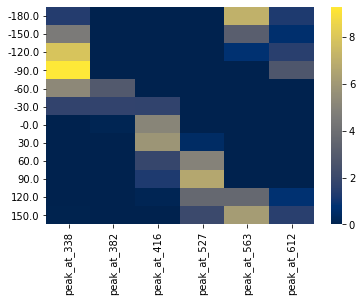

In [235]:
sns.heatmap(
    pd.DataFrame(
        (t_model.fitted_intensities_ - t_model.bg_ints_), 
        columns=measured_spectra.names, 
        index=np.round(hues/np.pi * 180, 0)
    ), 
    vmin=0, 
    #vmax=5, 
    cmap='cividis'
)